In [1]:
from utils import feature_importances
import featuretools as ft
from featuretools.primitives import RollingMean, NumericLag
import woodwork as ww
from evalml import AutoMLSearch
from evalml.model_understanding import graph_prediction_vs_actual_over_time


import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error

In this demo, we'll work to predict future daily average temperatures using historical temperature data. This is a time series machine learning problem, which requires special considerations during preprocessing, feature engineering, and model building.

To highlight the proess through which we can solve a time series problem, we'll build three models.

First, we'll build a baseline model; this will highlight the unique constraints for data-splitting and allow us to understand the problem definition. Then, we'll explore time series feature engineering by generating features with [Featuretools](https://featuretools.alteryx.com/), an open-source Python library for automatically creating features out of a set of related tables using a technique called Deep Feature Synthesis. Finally, we'll use EvalML's time series modeling to greatly simplify the process through which these models are built.

## Understanding Time Series Problems

Time series forecasting is different from other machine learning problems in that there is an inherent temporal ordering to the data. The ordering comes from a time index column, so at a specific point in time, we may have knowlege about earlier observations but not later ones. If the data is unordered, it’d be hard to see any overall trend or seasonality, but when sorted by date, any relationships that exist in the data can be seen and used when making predictions (winter is cold; summer is hot!). Notice how this is different from non-time series data, which can be presented in any order without having an impact on the resulting predictions.

Other demos in this repository explore this concept some. For example, the predict-remaining-useful-life demo is highly reliant on the temporal ordering of its data, as it is predicting when, in the future, an engine will need to be decommissioned. In that demo, the primary impact the data's temporal ordering has on modeling occurs in splitting the data into training and test data where we use a `cutoff_time` to determine when that split occurs. We'll have to account for the same things in this demo since we have to be very careful when splitting our data to not expose future observations in the feature engineering stage. 

But once the data is split, the predict-remaining-useful-life demo calculates aggregations over the entire life of the engine up until the last available time. In that case, that makes sense! The goal is to predict one future value (the remaining useful life) per engine, so we should look at its entire available history when making that prediction. There is an entire dataframe of engines for which we're predicting this value, but they are not dependent on one another. 

However, in this demo and in many time series problems, we're trying to predict a sequential series of values that are highly dependent on one another. In these cases, we can exploit the fact that more recent observations are more predictive than more distant ones--when trying to determine tomorrow's temperature, knowing today's temperature may be the most predictive piece of information we can get. We also only have one table in our dataset, so any aggregations have to be calculated over earlier data. We'll see the impact of this in what types of features we choose to build in the expanded Featuretools run.

For additional examples of time series demos that are similar to predict-remaining-useful-life, see predict-olympic-medals and predict-appointment-noshow.

## Load in Data

We’ll demonstrate how to build a time series model using the DailyDelhiClimateTrain dataset, which contains a `meantemp` target variable and a `date` time index. There are other columns, but for the purposes of simplicity, we'll only work with the target and time index columns. To include the others would bring this demo into the sphere of multivariate time series modeling, which brings its own host of complexity.

In [2]:
file_name = "DailyDelhiClimateTrain"
df = pd.read_csv(f"data/{file_name}.csv")

df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


Now, we'll do a quick sanity check that the data has some temporal pattern that we can exploit for modeling purposes.

First, we'll use a Woodwork method to check whether there is any column with a uniform sampling frequency. This is important, because it means that there is a constant amount of time between observations. A dataset that does not have a uniform sampling frequency can still be used for time series modeling, but the existence of that frequency is a good indicator that this dataset is ripe for time series modeling. For columns that have multiple datetime columns, checking for a frequency is also a good indicator for which could be the time index.

In [3]:
df.ww.init()
df.ww.infer_temporal_frequencies()

{'date': 'D'}

Indeed, one of the columns, `date`, has a daily frequency; we'll move forward with it as our time index.

Now, we’ll graph the data.

<AxesSubplot:xlabel='date'>

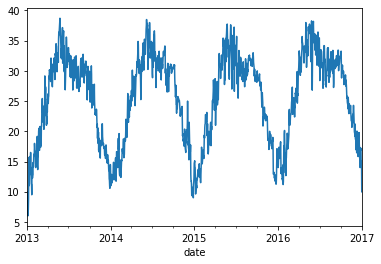

In [4]:
ts = df['meantemp']
ts.index = df['date']
ts.plot()

We can see a strong seasonality, which makes sense for temperature! In many places, the time of the year is indicative of what the weather will look like. Now, we'll build a baseline model that uses the most recently available data. 

But how do we define what data we have access to at different points in time? In many scenarios, this might be determined by how quickly we can get access to recent observations. Consider an example where we're recording data that takes a week to ingest; the earliest data we have access to is from seven days ago.

Since this demo is building a model using training and test data that we'll have access to in its entirety, we'll need to set some parameters arbitrarily. But these parameters will let us define the problem more formally. We'll stick with this problem configuration throughout the rest of the demo. 

## Problem Configuration
Here are a few concepts that give us our official problem configuration. They are taken from EvalML's [time series user guide](https://evalml.alteryx.com/en/stable/user_guide/timeseries.html#Running-AutoMLSearch):

**forecast_horizon**: The number of time periods we are trying to forecast. In this example, we’re interested in predicting the mean temperature for the next 5 days, so the value is 5.

**gap**: The number of time periods between the end of the training set and the start of the test set. We’re going to make predictions using data from three days prior to each observation.

**max_delay**: The maximum number of rows to look in the past from the current row in order to compute features. Here, we’ll use a max delay of 20.

**time_index**: The column of the training dataset that contains the date corresponding to each observation. Here, it's the `date` column.

Our problem can then be described as trying to predict the mean temperature 3 to 8 days out using temperature data from 20 days prior. 

In [5]:
# The only columns we'll want to use for modeling - makes this a univariate problem
time_index = "date"
target_col = 'meantemp'

# parameters as evalml uses them 
gap = 3
max_delay = 20
forecast_horizon = 5

Since we do not want to complicate the solution by performing multivariate time series modeling, we'll only use the time index column and target column for the rest of this demo. 

In [6]:
univariate_df = df[[time_index, target_col]]

Additionally, we'll want to have our data split up into training and testing data. We'll use the same split for both our baseline and Featuretools runs. We're leaving a `gap` number of observations between the train and test sets in order to not have the test dataset's lag feature use values that are technically before the test set begins or inside of the training set. 

In [7]:
split_point = int(univariate_df.shape[0]*.8)

# leave gap observations between training and test datasets
training_data = univariate_df[:split_point]
test_data = univariate_df[(split_point + gap):]

training_data

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
...,...,...
1164,2016-03-10,25.562500
1165,2016-03-11,25.066667
1166,2016-03-12,24.562500
1167,2016-03-13,24.250000


# Baseline Run

Our baseline run will only include one feature that is a delayed value from the `meantemp` column. That delayed value will be the first known value for each observation. 

### Feature Engineering

In [8]:
# Add a delayed target feature to both traning and test data
target_lag_training = training_data[target_col].shift(forecast_horizon + gap + 1)
target_lag_training.name = 'target_delay'
baseline_training = pd.concat([training_data, target_lag_training], axis=1)

target_lag_test = test_data[target_col].shift(forecast_horizon + gap + 1)
target_lag_test.name = 'target_delay'
baseline_test = pd.concat([test_data, target_lag_test], axis=1)

baseline_training

,date,meantemp,target_delay
0,2013-01-01,10.000000,NaN
1,2013-01-02,7.400000,NaN
2,2013-01-03,7.166667,NaN
3,2013-01-04,8.666667,NaN
4,2013-01-05,6.000000,NaN
...,...,...,...
1164,2016-03-10,25.562500,24.916667
1165,2016-03-11,25.066667,24.933333
1166,2016-03-12,24.562500,26.000000
1167,2016-03-13,24.250000,27.312500


### Format data for modeling

We won't want the datetime column in our data for modeling, we also need to remove the null values that were introduced in the delayed target feature, and last we need to pull the target column out. 

In [9]:
# Get rid of the time index column for modeling
baseline_training.drop(time_index, axis=1, inplace=True)
baseline_test.drop(time_index, axis=1, inplace=True)

# The lag feature introduces nans, so we remove those rows and pull out the target
X_train = baseline_training.dropna()
y_train = X_train.pop(target_col)

X_test = baseline_test.dropna()
y_test = X_test.pop(target_col)

X_train

,target_delay
9,10.000000
10,7.400000
11,7.166667
12,8.666667
13,6.000000
...,...
1164,24.916667
1165,24.933333
1166,26.000000
1167,27.312500


### Model Building

Now that we've formatted our training and test data for modeling, we can use the training data, `X_train` and the target column `y_train`, to fit the random forest regressor we've chosen as our estimator. Then, we use the test data, `X_test` to predict our target values and check its accuracy against `y_test`.

In [10]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

# Check the accuracy of our model
preds = reg.predict(X_test)
scores = median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(scores))

Median Abs Error: 2.01


We're using median absolue error as our objective function for determining how the model performs. The closer the score is to zero, the better.

We can also learn a bit more about our model by looking at the feature importances. 

In [11]:
high_imp_feats = feature_importances(X_train, reg, feats=10)

1: target_delay [1.000]
-----



As we only built one feature, the delayed feature, it makes sense that it has a feature importance of 1, meaning that predictions are based entirely on that value. This step will help us understand our model better when we engineer more features.

Next, we're going to expand our feature engineering step using Featuretools' deep feature synthesis (DFS). We'll utilize a few time-series specific primitives as well as some datetime primitives. 

# Feature Engineering Run 

We're going to use the same split that we used for the baseline run, so we'll work with the `training_data` and `test_data` dataframes from before.

To utilize Feturetools' time series capabilities, we'll first need to do two things:
1. Set up an [EntitySet](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html) for our data - this puts the data into a format that DFS can understand.
2. Set up [primitives](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html) for the DFS run - this is where we'll incorporate our time series problem configuration


### Feature Engineering with Featuretools

Our first step is setting up the `EntitySet` objects for both the training and testing data. Since our dataset only includes one table, this will be a quick process that will be identical for the training and testing data. The fact that the two EntitySets are the same in every aspect except for the number of rows will let us avoid running DFS twice. The feature definitions for one EntitySet can be used for the second as well!

In [12]:
training_es = ft.EntitySet(id='training_es')
# Adds an index column to the data, so the "temperatures"
# dataframe will have 3 columns
training_es.add_dataframe(training_data.copy(), 
                 dataframe_name='temperatures', 
                 index='id', 
                 make_index=True, 
                 time_index=time_index)



Entityset: training_es
  DataFrames:
    temperatures [Rows: 1169, Columns: 3]
  Relationships:
    No relationships

In [13]:
# The EntitySet made from the testing data will be created in exactly the same way
test_es = ft.EntitySet(id='test_es')
# Adds an index column to the data, so the "temperatures"
# dataframe will have 3 columns
test_es.add_dataframe(test_data.copy(), 
                 dataframe_name='temperatures', 
                 index='id', 
                 make_index=True, 
                 time_index=time_index)


Entityset: test_es
  DataFrames:
    temperatures [Rows: 290, Columns: 3]
  Relationships:
    No relationships

Now, we'll set up our primitives for DFS. There will be three types of primitives:

- **Datetime primitives** - these extract features from datetime columns
- **Rolling primitives** - these perform aggregate calculations over rolling windows within a single column. Parameters can be set that allow an observation's window to be entirely before the observation occurs, which is important for not exposing our target variable. 
- **Lagging primitives** - these are primitive versions of the delayed target feature from the baseline run. We'll define multiple of these with different delays.

We use the `gap`, `forecast_horizon`, and `max_delay` parameters from before to set our primitive parameters.

In [14]:
# Rolling gap is comprised of both our `gap` parameter and the forecast horizon, 
# because they determine the first observation we have access to.
# They are also used to define our Numeric Lag primitives
rolling_gap = forecast_horizon + gap

# The .25 is a heuristic to only use a portion of the max_delay for the window length
rolling_window_length = int(.25*max_delay) + 1 # a quarter is a heuristic here 
# Min periods is a pandas parameter, and it just stops us from including partial calculations before the windows have 
# all the possible observations
rolling_min_periods = int(.25*max_delay) + 1

datetime_primitives = [ 'Month', "Year"]
delaying_primitives = [NumericLag(periods=t + forecast_horizon + gap) for t in range(rolling_window_length)]
rolling_mean_primitive = RollingMean(rolling_window_length, 
                                               gap=rolling_gap,
                                              min_periods=rolling_min_periods)

Now that we have all of our time series primitives defined, we can pass them into a DFS call. DFS returns two objects: a feature matrix and a list of feature definitions. We'll need the feature matrix built from the training data to use for fitting the model, and that is what we're getting with this DFS run, but we'll also need the test feature matrix to predict on, so we will use the feature definitions from the DFS call and calculate the test feature matrix directly using them. 

In [15]:
# DFS Run - calculates feature matrix and the feature definitions
train_fm, feature_defs = ft.dfs(entityset=training_es, 
               target_dataframe_name='temperatures', 
               max_depth=1,
               trans_primitives = datetime_primitives 
                            + delaying_primitives 
                            + [ rolling_mean_primitive ]
              )

# Reuse the feature definitions for the test data
test_fm = ft.calculate_feature_matrix(feature_defs, test_es)

### Format data for modeling 

Again, we'll need to remove any null values in the data. In this case, all of our lagging primitives and our rolling 
mean primitive will have introduced NaNs that we need to remove. 

In [16]:
# Separate in to X and y objects for modeling
X_train = train_fm.dropna()
y_train = X_train.pop(target_col)

# Do the same for the test data 
X_test = test_fm.dropna()
y_test = X_test.pop(target_col)

X_train

,MONTH(date),"NUMERIC_LAG(date, meantemp, periods=10)","NUMERIC_LAG(date, meantemp, periods=11)","NUMERIC_LAG(date, meantemp, periods=12)","NUMERIC_LAG(date, meantemp, periods=13)","NUMERIC_LAG(date, meantemp, periods=8)","NUMERIC_LAG(date, meantemp, periods=9)","ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6)",YEAR(date)
id,,,,,,,,,
13,1,8.666667,7.166667,7.400000,10.000000,7.000000,6.000000,7.705556,2013
14,1,6.000000,8.666667,7.166667,7.400000,7.000000,7.000000,7.205556,2013
15,1,7.000000,6.000000,8.666667,7.166667,8.857143,7.000000,7.448413,2013
16,1,7.000000,7.000000,6.000000,8.666667,14.000000,8.857143,8.587302,2013
17,1,8.857143,7.000000,7.000000,6.000000,11.000000,14.000000,8.976190,2013
...,...,...,...,...,...,...,...,...,...
1164,3,23.875000,23.000000,22.800000,22.800000,24.933333,24.916667,23.720833,2016
1165,3,24.916667,23.875000,23.000000,22.800000,26.000000,24.933333,24.254167,2016
1166,3,24.933333,24.916667,23.875000,23.000000,27.312500,26.000000,25.006250,2016


### Model Building

The modeling step will be the exact same as the baseline run, but now we have nine different features instead of just one!

In [17]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
scores = median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(scores))

Median Abs Error: 1.64


We can see that the median absolute error has decreased relative to the baseline run, which means that this model is more accurate than the basline.

We can also take a look at the feature importances to see which contribute the most to the model.

In [18]:
high_imp_feats = feature_importances(X_train, reg, feats=100)

1: NUMERIC_LAG(date, meantemp, periods=8) [0.452]
2: ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6) [0.315]
3: NUMERIC_LAG(date, meantemp, periods=9) [0.109]
4: MONTH(date) [0.058]
5: NUMERIC_LAG(date, meantemp, periods=10) [0.018]
6: NUMERIC_LAG(date, meantemp, periods=13) [0.016]
7: NUMERIC_LAG(date, meantemp, periods=11) [0.012]
8: NUMERIC_LAG(date, meantemp, periods=12) [0.012]
9: YEAR(date) [0.007]
-----



Featuretools simplified what would have been a messy feature engineering process, and it got us a better model, but there were still a lot of steps to get to this point. Luckily, EvalML's Time Series Regression problem type lets us greatly simplify this process while building the exact same set of features. 

## Use Time Series Regression Problem From EvalML
We will now use EvalML to build a model that is very similar to the one we just built with the help of Featuretools. EvalML's time series regression problem type does the same feature engineering usinf Featuretools that we just did under the hood. That, along with the simplicity with which we can split our data and the fact that we run multiple pipelines shows the power of EvalML.

### Data Splitting

Here, we can use EvalML's time series data splitting capabilities, which will leave us with data that has its time index in tact.

In [19]:
import evalml

univariate_df = df[[time_index, target_col]]

X = univariate_df
y = univariate_df.pop(target_col)

X_train, X_test, y_train, y_test = evalml.preprocessing.split_data(X, y,
                                                                   problem_type='time series regression',
                                                                   test_size=.2,
                                                                  problem_configuration={"gap": gap, 
                                                                                         "max_delay": max_delay,
                                                                                         "forecast_horizon": forecast_horizon,
                                                                                         "time_index": time_index},)

X_train

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1164,2016-03-10
1165,2016-03-11
1166,2016-03-12
1167,2016-03-13


### Model Building 
Now we can perform AutoMLSearch, which will provide us with six pipelines, one of which is the same as our baseline pipeline from above! 

In [20]:
from evalml import AutoMLSearch

automl = AutoMLSearch(X_train, y_train, problem_type="time series regression",
                      max_batches=1,
                      problem_configuration={"gap": gap, 
                                             "max_delay": max_delay,
                                             "forecast_horizon": forecast_horizon, 
                                             "time_index": time_index},
                      allowed_model_families=["xgboost", "random_forest", "linear_model", "extra_trees",
                                              "decision_tree"],
                      objective='MedianAE'
                      )
# Fit and predict on the model
automl.search()

Time series support in evalml is still in beta, which means we are still actively building its core features. Please be mindful of that when running search().
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.504e+02, tolerance: 1.058e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e+03, tolerance: 3.066e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+03, tolerance: 4.692e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+03, tolerance: 6.109e+00


Below are the summaries of the six pipelines that were run.

In [21]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,1,Elastic Net Regressor w/ Imputer + Time Series...,1,1.735829,0.295337,1.735829,9.435011,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,5,Extra Trees Regressor w/ Imputer + Time Series...,5,1.798169,0.409076,1.798169,6.182511,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,3,Random Forest Regressor w/ Imputer + Time Seri...,3,1.826079,0.432566,1.826079,4.726298,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,0,Time Series Baseline Regression Pipeline,0,1.916667,0.314576,1.916667,0.000000,False,{'Time Series Featurizer': {'time_index': 'dat...
4,2,XGBoost Regressor w/ Imputer + Time Series Fea...,2,1.976012,0.429196,1.976012,-3.096295,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,4,Decision Tree Regressor w/ Imputer + Time Seri...,4,2.134427,0.469706,2.134427,-11.361431,False,{'Imputer': {'categorical_impute_strategy': 'm...


The `mean_cv_score` shown here is the median absolute error for predictions calculated using subsets of the training data. To compare our results to our baseline and Featuretools runs from above, we'll have to score the test data.

We'll investigate further into pipeline #3, since it's the Random Forest Regressor, which is what we used above.

In [22]:
pipeline =  automl.get_pipeline(3)
pipeline.fit(X_train, y_train)
pipeline_score = pipeline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
pipeline_score

1.3376558744306308

Our model creatued using EvalML is performing slightly better than our Featuretools run! We can also inspect the feature importances. The top four features are in slightly different orders, but they are the same as our Featuretools run.

In [23]:
pipeline.feature_importance

,feature,importance
0,target_delay_8,0.506269
1,target_rolling_mean,0.354584
2,date_month,0.056376
3,target_delay_9,0.043163
4,target_delay_17,0.008510
5,target_delay_15,0.005156
6,target_delay_13,0.005006
7,target_delay_12,0.004257
8,target_delay_14,0.003694
9,target_delay_16,0.003680


We'll also take a look at the baseline pipeline and see how it compares to the baseline pipeline we built ourselves.

In [24]:
baseline = automl.get_pipeline(0)
baseline.fit(X_train, y_train)
naive_baseline_score = baseline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
naive_baseline_score

2.0249999999999986

Indeed, our baseline score from EvalML is very similar to the one we calculated ourselves, and below we can see the feature importance of 1 for the single delayed feature. The other two features with zero importance are side effects of the AutoMLSearch process and were not included in the model itself.

In [25]:
baseline.feature_importance

,feature,importance
0,target_delay_8,1
1,date,0
2,target_rolling_mean,0


### Visualizing Predictions

Beyond our use of median absolute error for evaluating models, we can also use our eyes! Here are two graphs of the predictions.

In [29]:
fig = graph_prediction_vs_actual_over_time(pipeline, X_test, y_test, X_train, y_train, dates=X_test['date'])
fig.update_layout(title="Ramdom Forest Regressor Predictions vs target over time")
fig

In [30]:
fig = graph_prediction_vs_actual_over_time(baseline, X_test, y_test, X_train, y_train, dates=X_test['date'])
fig.update_layout(title="Baseline Predictions vs target over time")
fig